# Keras - Bidirectional LSTM 

In [1]:
ls

classifier-keras-text.ipynb       LICENSE.txt   main.py  __pycache__/
 Keras-Bidirectional-LSTM .ipynb  load_data.py  models/  README.md


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

### Import keras Libs

In [88]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, GlobalMaxPool1D
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import initializers, regularizers, constraints, optimizers, layers
import sys, os, re, csv, codecs
from keras.utils import np_utils

In [3]:
EMBEDDING_FILE = f'./.vector_cache/glove.6B.50d.txt'
TRAIN_DATA_FILE = f'../../vasu/clean.csv'
TEST_DATA_FILE = f'/ebs1/kaggle_datasets/data/query_test.csv'

In [60]:
# max_features = 20000
max_features = 17112
maxlen = 100
embed_size = 50

In [5]:
train = pd.read_csv(TRAIN_DATA_FILE)

In [24]:
train = train.dropna(how='any')  
X = train['query'].values
Y = train['L'].values

In [26]:
train['query'].values.shape


(100545,)

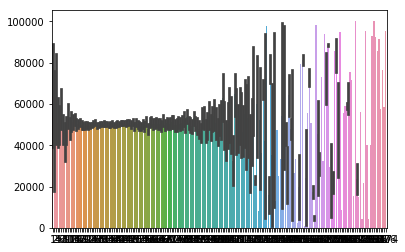

In [13]:
sns.barplot([len(i) for i in X],[i for i in range(len(X))])

In [14]:
.shape#train = train.sample(frac=1)
test = pd.read_csv(TEST_DATA_FILE,sep='|')

In [15]:
test.head()

,QueryId,Query
0,1,ASKED ABOUT ATTACK APHIDS ON TUR?
1,2,ASKED ABOUT ATTACK BLIGHT ON SOYBEAN?
2,3,ASKED ABOUT ATTACK FUNGAL ATTACK ON CHILLI?
3,4,ASKED ABOUT ATTACK OF SUCKING PEST ON SOYABEAN ?
4,5,ASKED ABOUT ATTACK RED MITES ON COTTON?


In [32]:
list_sentences_test = test['Query'].fillna('New_Gen').values

In [17]:
#print(list_sentences_test)

In [61]:
tokenizer = text.Tokenizer(num_words=max_features)

In [62]:
print(tokenizer)

In [63]:
tokenizer.fit_on_texts(list(list_sentences_train) + list(list_sentences_test))

In [64]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [65]:
print(list_tokenized_train)

[[27, 162, 3, 15, 100], [4, 13, 6, 1, 290], [13, 303, 612], [9, 7, 95, 34, 37, 7718, 1344], [9, 1089, 1245, 2, 7719, 5528, 1, 7720], [4, 13, 21, 10, 5, 1309, 2573, 2574, 40, 1, 29, 12], [8, 2, 6, 64, 7721, 160], [20, 2, 2097, 299, 1, 97], [4, 13, 21, 10, 5, 960, 101, 1, 389], [2, 1246, 12], [9, 7, 2, 44, 81, 5, 1, 535], [2575, 808, 3, 109], [153, 44, 4, 2, 6], [9, 7, 2, 59, 51, 5, 1, 7722], [9, 7, 2, 32, 5, 1, 1641, 12], [207, 618, 3861, 83, 1130, 912, 4521, 7723, 30], [4, 13, 158, 366, 625, 872, 1048], [26, 3, 2393, 34, 102], [11, 19, 10, 17, 4, 2, 21, 10, 108, 49, 3, 56], [4, 13, 21, 10, 5, 66, 1532, 1, 29, 12], [8, 2, 50, 4, 3, 161, 1, 7724], [9, 7, 80, 7725, 3, 5529, 7726], [29, 287, 406, 159, 16], [42, 101, 1, 228, 39, 390, 88], [125, 28, 78], [9, 7, 43, 5, 3, 120], [36, 62, 1, 228, 12], [8, 2, 5, 3, 66, 82, 1, 102], [38, 16, 1, 1696], [8, 2, 1280, 307, 504, 58, 60], [8, 2, 6, 22, 14, 1310, 18], [8, 2, 141, 39, 50, 41], [104, 7, 543, 149, 30], [1227, 50, 288], [9, 7, 5, 3, 59, 51,

In [66]:
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [67]:
X_t.shape

(100545, 100)

In [68]:
X_te.shape

(16032, 100)

### Read Glove Word Vectors : word -> vector

In [69]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [70]:
all_embs = np.stack(embeddings_index.values())

In [71]:
emb_mean,emb_std = all_embs.mean(), all_embs.std()

In [72]:
emb_mean,emb_std

(0.020940498, 0.6441043)

In [73]:
word_index = tokenizer.word_index

In [74]:
print(word_index)

{'in': 1, 'about': 2, 'of': 3, 'information': 4, 'control': 5, 'weather': 6, 'me': 7, 'asking': 8, 'tell': 9, 'to': 10, 'farmer': 11, 'crop': 12, 'regarding': 13, 'for': 14, 'paddy': 15, 'management': 16, 'know': 17, 'district': 18, 'want': 19, 'asked': 20, 'how': 21, 'report': 22, 'insect': 23, 'problem': 24, 'leaf': 25, 'attack': 26, 'fertilizer': 27, 'ki': 28, 'cotton': 29, 'hai': 30, 'wants': 31, 'weed': 32, 'borer': 33, 'on': 34, 'needs': 35, 'plant': 36, 'sugarcane': 37, 'nutrient': 38, 'gram': 39, 'disease': 40, 'rate': 41, 'flower': 42, 'pest': 43, 'the': 44, 'fruit': 45, 'pradesh': 46, 'and': 47, 'madhya': 48, 'growth': 49, 'market': 50, 'rot': 51, 'gourd': 52, 'brinjal': 53, 'wheat': 54, 'mango': 55, 'tomato': 56, 'onion': 57, 'contact': 58, 'root': 59, 'number': 60, 'spray': 61, 'protection': 62, 'sucking': 63, 'forecast': 64, 'fungal': 65, 'white': 66, 'variety': 67, 'block': 68, 'blight': 69, 'dose': 70, 'varieties': 71, 'groundnut': 72, 'stem': 73, 'state': 74, 'maize': 7

In [75]:
nb_words = min(max_features, len(word_index))

In [76]:
nb_words

17112

In [77]:
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

In [78]:
embedding_matrix

array([[-0.86059894,  1.51697162,  1.65424795, ...,  0.77626331,
         0.47498681, -0.73083602],
       [-0.08450652, -0.59091775, -0.19437616, ..., -0.25211193,
        -1.35634073,  0.19107165],
       [ 0.33895582, -1.10748264,  0.37497987, ...,  0.01919983,
        -1.20152708,  0.04891228],
       ...,
       [ 0.62888345,  0.09956215,  0.33322184, ...,  0.24563276,
        -0.37564717,  0.22605975],
       [-0.77384939,  0.48001753,  1.69756824, ...,  0.59450176,
        -0.45843544, -0.27680715],
       [-0.12096613, -0.32380766,  0.76866665, ..., -0.9547661 ,
         1.35056922, -0.25877367]])

In [79]:
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [80]:
embedding_matrix

array([[-0.86059894,  1.51697162,  1.65424795, ...,  0.77626331,
         0.47498681, -0.73083602],
       [ 0.33041999,  0.24995001, -0.60873997, ..., -0.50703001,
        -0.027273  , -0.53285003],
       [ 0.89466   ,  0.36603999,  0.37588   , ...,  0.55997998,
        -0.66592997,  0.12177   ],
       ...,
       [ 0.62888345,  0.09956215,  0.33322184, ...,  0.24563276,
        -0.37564717,  0.22605975],
       [-0.77384939,  0.48001753,  1.69756824, ...,  0.59450176,
        -0.45843544, -0.27680715],
       [-0.12096613, -0.32380766,  0.76866665, ..., -0.9547661 ,
         1.35056922, -0.25877367]])

In [103]:
def get_model():
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [104]:
model = get_model()

In [55]:
# batch_size = 32
# epochs = 2

In [91]:
X_t.shape
Y.shape

(100545,)

In [93]:
Y

array([1, 8, 8, ..., 6, 1, 0])

In [101]:
Y.shape
Y_train = np_utils.to_categorical(Y,num_classes=10)

In [ ]:
model.fit(X_t, Y_train, batch_size=32, epochs=2, validation_split=0.1)

Train on 90490 samples, validate on 10055 samples
Epoch 1/2
14272/90490 [===>..........................] - ETA: 14:03 - loss: 0.2333 - acc: 0.9219

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 306       
Total para

## Submission File Generate

In [58]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)


153164/153164 [==============================] - 120s 783us/step


In [59]:
sample_submission = pd.read_csv(f'sample_submission.csv')


In [60]:
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv', index=False)